In [8]:
# Instalacje lol
!pip install spacy
!python -m spacy download pl_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/pl_core_news_sm-3.8.0/pl_core_news_sm-3.8.0-py3-none-any.whl (20.2 MB)
[+] Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [35]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer, models, losses
from sentence_transformers.datasets import DenoisingAutoEncoderDataset
from torch.utils.data import DataLoader
import random

# Ładujemy model spaCy dla polskiego (dobrze radzi sobie też z mieszanym tekstem)
nlp = spacy.load("pl_core_news_sm")

# Funkcja szumu - usuwa losowe słowa po tokenizacji spaCy
def noise_fn(text, del_ratio=0.2):
    doc = nlp(text)
    words = [token.text for token in doc]
    n = len(words)
    if n == 0:
        return text
    n_del = max(1, int(n * del_ratio))
    del_indices = sorted(random.sample(range(n), n_del), reverse=True)
    for idx in del_indices:
        del words[idx]
    return ' '.join(words)

# Wczytujemy IFC
df = pd.read_csv("../data/ifc_sample.csv")

# Wybieramy kolumnę z tekstem
sentences = df['Text'].tolist()

# Wczytujemy model bazowy
base_model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
word_embedding_model = models.Transformer(base_model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Przygotowujemy dataset TSDAE i DataLoader z funkcją szumu
train_dataset = DenoisingAutoEncoderDataset(sentences, noise_fn=noise_fn)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Definiujemy loss
train_loss = losses.DenoisingAutoEncoderLoss(model=model)

# Trening
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=5,
    show_progress_bar=True
)

# Zapisujemy model
model.save("../models/tsdae_finetuned_ifc")

Some weights of BertLMHeadModel were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.laye

Step,Training Loss


Wczytywanie zapisanych embeddingów CCI...
Liczba embeddingów CCI: 11
Top-1 Accuracy: 50.00%


,GlobalId,Opis_IFC,Przewidywany_Kod_CCI,Przewidywana_Klasa_CCI,Podobieństwo,Prawdziwy_Kod_CCI,Poprawność
0,2N3O4P,"Balustrada stalowa, IfcRailing, Balustrada z w...",24.61.10,Balustrady,0.7518,24.61.10,True
1,9K0L1M,"Dach dwuspadowy, IfcRoof, Konstrukcja drewnian...",22.11.10,Dachy,0.7459,22.11.10,True
2,1X2Y3Z,"Ściana zewnętrzna, IfcWall, Ściana zewnętrzna,...",21.11.10,Ściany zewnętrzne,0.7256,21.11.10,True
3,4A5B6C,"Drzwi jednoskrzydłowe, IfcDoor, Drzwi z drewna...",23.32.10,Drzwi wewnętrzne,0.6693,23.32.10,True
4,0A1B2C,"Strop żelbetowy, IfcSlab, Strop monolityczny z...",21.51.10,Fundamenty,0.5786,22.31.10,False
5,8T9U0V,"Drzwi przeciwpożarowe, IfcDoor, Drzwi EI60 sta...",23.32.10,Drzwi wewnętrzne,0.5750,23.31.10,False
6,3E4F5G,"Słup stalowy, IfcColumn, Słup stalowy HEA, wys...",22.31.10,Stropy,0.5564,21.41.10,False
7,7D8E9F,"Okno PCV, IfcWindow, Okno dwuszybowe PCV, rozw...",23.21.10,Okna,0.5520,23.21.10,True
8,5Q6R7S,"Schody prefabrykowane, IfcStair, Schody żelbet...",22.31.10,Stropy,0.5480,23.41.10,False
9,6H7I8J,"Płyta fundamentowa, IfcSlab, Płyta żelbetowa, ...",22.31.10,Stropy,0.4998,21.51.10,False


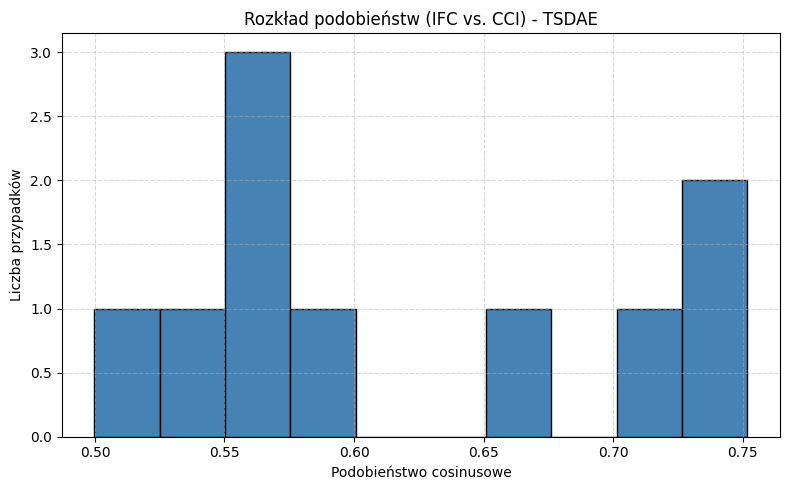

Wyniki zapisane do ../results/tsdae_predictions.json


In [36]:
# Analiza wyników z TSDAE
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import json

# Wczytujemy wytrenowany model TSDAE
model = SentenceTransformer("../models/tsdae_finetuned_ifc")

# Wczytujemy klasy CCI
with open("../data/cci_sample.json", "r", encoding="utf-8") as f:
    cci_data = json.load(f)
cci_df = pd.DataFrame(cci_data)

# Ścieżka do pliku z embeddingami CCI (generujemy nowe embeddingi z nowym modelem)
cci_emb_path = "../data/cci_embeddings_tsdae.npy"

if os.path.exists(cci_emb_path):
    print("Wczytywanie zapisanych embeddingów CCI...")
    cci_embeddings = np.load(cci_emb_path)
else:
    print("Generowanie embeddingów CCI i zapis do pliku...")
    cci_embeddings = model.encode(cci_df["full_text"].tolist(), convert_to_tensor=False)
    np.save(cci_emb_path, cci_embeddings)

print(f"Liczba embeddingów CCI: {len(cci_embeddings)}")

# Wczytujemy dane IFC
ifc_df = pd.read_csv("../data/ifc_sample.csv")

# Generujemy embeddingi IFC
ifc_embeddings = model.encode(ifc_df["Text"].tolist(), convert_to_tensor=False)

# Klasyfikujemy IFC względem CCI
results = []
threshold = 0.065  # można zmienić wg uznania

for i, ifc_emb in enumerate(ifc_embeddings):
    similarities = util.cos_sim(ifc_emb, cci_embeddings)[0]
    best_idx = similarities.argmax().item()
    best_score = similarities[best_idx].item()

    if best_score < threshold:
        predicted_code = "N/A"
        predicted_name = "Brak jednoznacznej klasyfikacji"
    else:
        predicted_code = cci_df.loc[best_idx, "code"]
        predicted_name = cci_df.loc[best_idx, "name"]

    true_code = ifc_df.loc[i, "Prawdziwy_Kod_CCI"] if "Prawdziwy_Kod_CCI" in ifc_df.columns else None

    results.append({
        "GlobalId": ifc_df.loc[i, "GlobalId"],
        "Opis_IFC": ifc_df.loc[i, "Text"],
        "Przewidywany_Kod_CCI": predicted_code,
        "Przewidywana_Klasa_CCI": predicted_name,
        "Podobieństwo": round(best_score, 4),
        "Prawdziwy_Kod_CCI": true_code
    })

results_df = pd.DataFrame(results)

# Ewaluacja
if results_df["Prawdziwy_Kod_CCI"].notnull().all():
    results_df["Poprawność"] = results_df["Przewidywany_Kod_CCI"] == results_df["Prawdziwy_Kod_CCI"]
    accuracy = results_df["Poprawność"].mean()
    print(f"Top-1 Accuracy: {accuracy:.2%}")
else:
    print("Brak kolumny Prawdziwy_Kod_CCI lub zawiera puste wartości.")

# Sortowanie po podobieństwie
results_df.sort_values("Podobieństwo", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Podgląd top 10
from IPython.display import display
display(results_df.head(10))

# Histogram podobieństw
plt.figure(figsize=(8, 5))
plt.hist(results_df["Podobieństwo"], bins=10, color="steelblue", edgecolor="black")
plt.title("Rozkład podobieństw (IFC vs. CCI) - TSDAE")
plt.xlabel("Podobieństwo cosinusowe")
plt.ylabel("Liczba przypadków")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Eksport wyników do JSON
output_path = "../results/tsdae_predictions.json"
tsdae_output = []

for _, row in results_df.iterrows():
    tsdae_output.append({
        "GlobalId": row["GlobalId"],
        "Opis": row["Opis_IFC"],
        "Predykcja": {
            "Kod_CCI": row["Przewidywany_Kod_CCI"],
            "Nazwa": row["Przewidywana_Klasa_CCI"],
            "Podobieństwo": row["Podobieństwo"]
        }
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(tsdae_output, f, ensure_ascii=False, indent=2)

print(f"Wyniki zapisane do {output_path}")